# Implementación MLP secuencial en Python

#### Carga de datos MNIST usando Tensorflow

In [1]:
%pip install tensorflow 

#### Importaciones necesarias 

In [12]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import time

data = mnist.load_data()

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("Dimensión de todas las imágenes de entrenamiento ",  x_train.shape)
print("Dimensión de todas las imágenes de prueba ",  x_test.shape)

Dimensión de todas las imágenes de entrenamiento  (60000, 28, 28)
Dimensión de todas las imágenes de prueba  (10000, 28, 28)


#### Visualización del dataset MNIST para entrenamiento

Ejemplos de datos de entrenamiento del conjunto MNIST


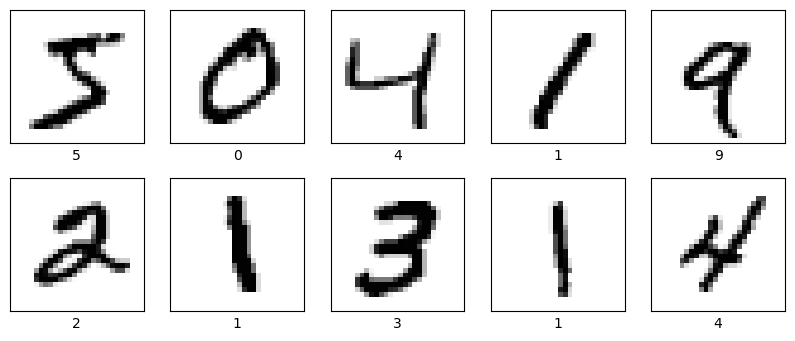

In [13]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plt.figure(figsize=(10,4))
print("Ejemplos de datos de entrenamiento del conjunto MNIST")

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])

#### Aplanar y normalizar el conjunto de entrenamiento y el de pruebas

In [14]:
(data_x_train, data_y_train), (data_x_test, data_y_test) = mnist.load_data()

# Preprocesamiento: aplanar y normalizar, y poner ejemplos en columnas
X_train = data_x_train.reshape(data_x_train.shape[0], 28*28).T / 255.0  # shape (784, m_train)
X_test  = data_x_test.reshape(data_x_test.shape[0], 28*28).T / 255.0    # shape (784, m_test)
Y_train = data_y_train  # shape (m_train,)
Y_test  = data_y_test

print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)

X_train shape: (784, 60000)
X_test  shape: (784, 10000)
Y_train shape: (60000,)


## 0. Notación

In [15]:
input_size  = 28*28
hidden_size = 512
output_size = 10

def init_params(hidden_size=hidden_size, input_size=input_size, output_size=output_size):
    W1 = np.random.randn(hidden_size, input_size) * 0.01  
    b1 = np.zeros((hidden_size, 1))                       
    W2 = np.random.randn(output_size, hidden_size) * 0.01 
    b2 = np.zeros((output_size, 1))                       
    return W1, b1, W2, b2

## 1. Forward

In [16]:
def relu(Z):
    return np.maximum(0, Z)

def d_relu(Z):
    return (Z > 0).astype(float)

def softmax(Z):
    Z_shift = Z - np.max(Z, axis=0, keepdims=True)
    expZ = np.exp(Z_shift)
    return expZ / np.sum(expZ, axis=0, keepdims=True)

# One-hot: devuelve shape (10, m)
def one_hot(Y, num_classes=output_size):
    m = Y.size
    OH = np.zeros((num_classes, m))
    OH[Y, np.arange(m)] = 1
    return OH

def forward(X, W1, b1, W2, b2):
    Z1 = W1.dot(X) + b1          
    A1 = relu(Z1)                
    Z2 = W2.dot(A1) + b2         
    A2 = softmax(Z2)             
    cache = (X, Z1, A1, Z2, A2)
    return A2, cache

## 2. Loss

In [17]:
def compute_loss(A2, Y):
    m = Y.size
    Y_oh = one_hot(Y, num_classes=output_size)  # (10,m)
    log_probs = np.log(A2 + 1e-12)
    loss = -np.sum(Y_oh * log_probs) / m
    return loss

## 3. Backward

In [18]:
def backward(cache, W2, Y):
    X, Z1, A1, Z2, A2 = cache
    m = Y.size
    Y_oh = one_hot(Y, num_classes=output_size)  # (10,m)

    dZ2 = A2 - Y_oh
    dW2 = (1.0 / m) * dZ2.dot(A1.T)
    db2 = (1.0 / m) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = W2.T.dot(dZ2)
    dZ1 = dA1 * d_relu(Z1)
    dW1 = (1.0 / m) * dZ1.dot(X.T)
    db1 = (1.0 / m) * np.sum(dZ1, axis=1, keepdims=True)

    return dW1, db1, dW2, db2


## 4. Actualización de pesos

In [19]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2
    return W1, b1, W2, b2

In [20]:
def predict(A2):
    return np.argmax(A2, axis=0)

def accuracy(preds, Y):
    return np.mean(preds == Y)

### Zona de entrenamiento con 60.000 imágenes

In [21]:
def train(X, Y, epochs=10, batch_size=128, lr=0.01, hidden_size=hidden_size):
    W1, b1, W2, b2 = init_params(hidden_size, input_size, output_size)
    m = X.shape[1]
    for epoch in range(epochs):
        # shuffle
        start_time = time.time()
        
        perm = np.random.permutation(m)
        X_sh = X[:, perm]
        Y_sh = Y[perm]

        epoch_loss = 0.0
        epoch_acc  = 0.0
        num_batches = 0

        for i in range(0, m, batch_size):
            X_batch = X_sh[:, i:i+batch_size]
            Y_batch = Y_sh[i:i+batch_size]

            A2, cache = forward(X_batch, W1, b1, W2, b2)
            loss = compute_loss(A2, Y_batch)
            dW1, db1, dW2, db2 = backward(cache, W2, Y_batch)

            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, lr)

            preds = predict(A2)
            acc = accuracy(preds, Y_batch)

            epoch_loss += loss
            epoch_acc  += acc
            num_batches += 1

        avg_loss = epoch_loss / num_batches
        avg_acc  = epoch_acc  / num_batches
        finish_time = time.time()
        tiempo = finish_time - start_time
        print(f"Epoch {epoch+1}/{epochs} - loss: {avg_loss:.2f} - acc: {avg_acc*100:.2f}%  -  time: {tiempo:.2f}s")

    return W1, b1, W2, b2

In [22]:
initial_time = time.time()
print("Starting training sequential Python ...")
W1_trained, b1_trained, W2_trained, b2_trained = train(X_train, Y_train, epochs=10, batch_size=128, lr=0.01)
end_time = time.time()
total_time = end_time - initial_time
print(f"Total training time: {total_time:.2f} seconds")


Starting training sequential Python ...
Epoch 1/10 - loss: 2.05 - acc: 64.24%  -  time: 4.70s
Epoch 2/10 - loss: 1.06 - acc: 79.07%  -  time: 3.85s
Epoch 3/10 - loss: 0.64 - acc: 84.94%  -  time: 3.47s
Epoch 4/10 - loss: 0.50 - acc: 87.16%  -  time: 3.67s
Epoch 5/10 - loss: 0.44 - acc: 88.27%  -  time: 3.70s
Epoch 6/10 - loss: 0.40 - acc: 89.05%  -  time: 3.32s
Epoch 7/10 - loss: 0.38 - acc: 89.54%  -  time: 3.36s
Epoch 8/10 - loss: 0.36 - acc: 89.87%  -  time: 3.53s
Epoch 9/10 - loss: 0.35 - acc: 90.22%  -  time: 3.48s
Epoch 10/10 - loss: 0.34 - acc: 90.49%  -  time: 3.45s
Total training time: 36.57 seconds


### Zona de pruebas

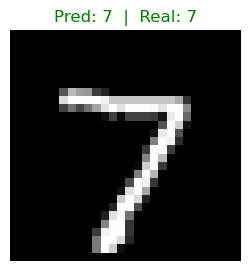

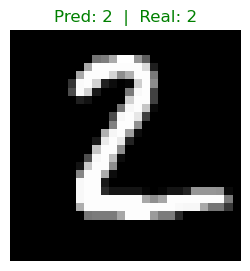

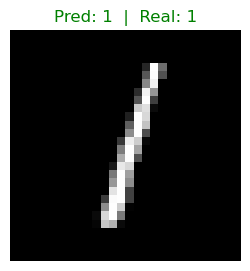

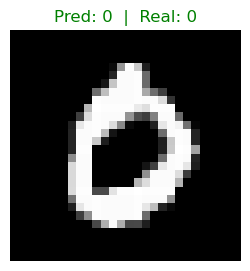

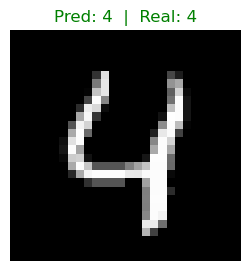

----- RESUMEN -----
Aciertos: 5/5
Accuracy en estas 5 imágenes: 100.00%


In [26]:
def predict_single(x28, W1, b1, W2, b2):
    # Convertir 28x28 → vector columna (784,1)
    x = x28.reshape(784, 1) / 255.0
    
    # Forward
    A2, _ = forward(x, W1, b1, W2, b2)
    pred = np.argmax(A2, axis=0)[0]
    return pred

def show_first_5_predictions(x_test, y_test, W1, b1, W2, b2, n=5):
    correct = 0

    for i in range(n):
        img = x_test[i]            # (28, 28)
        real_label = y_test[i]

        pred_label = predict_single(img, W1, b1, W2, b2)

        if pred_label == real_label:
            color = "green"
            correct += 1
        else:
            color = "red"

        plt.figure(figsize=(3,3))
        plt.imshow(img, cmap='gray')
        plt.title(f"Pred: {pred_label}  |  Real: {real_label}", color=color)
        plt.axis("off")
        plt.show()

    print("----- RESUMEN -----")
    print(f"Aciertos: {correct}/{n}")
    print(f"Accuracy en estas {n} imágenes: {100*correct/n:.2f}%")

show_first_5_predictions(data_x_test, data_y_test, W1_trained, b1_trained, W2_trained, b2_trained, n=5)